In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


import os
import sys
import math
import time
import numpy as np
import tensorflow as tf
from tqdm import tqdm, trange
from matplotlib import pyplot as plt
from tensorflow import keras as K
import glob

print("tf: {}".format(tf.version.VERSION))
print("tf.keras: {}".format(K.__version__))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

tf: 2.1.0
tf.keras: 2.2.4-tf
Num GPUs Available:  1


In [2]:
sys.path.append('../SketchRNN_tf2')
from sketchrnn import models, dataset, utils

In [3]:

def visualize(sketch):
    X = []
    Y = []

    tmp_x, tmp_y = [], []
    sx = sy = 0
    for p in sketch:
        sx += p[0]
        sy += p[1]
        tmp_x.append(sx)
        tmp_y.append(-sy)
        if p[2] == 1:
            X.append(tmp_x)
            Y.append(tmp_y)
            tmp_x, tmp_y = [], []

    X.append(tmp_x)
    Y.append(tmp_y)

    for x, y in zip(X, Y):
        plt.plot(x, y)

    # save the image.
    # plt.savefig("sample.png")

    # show the plot
    plt.axes().set_aspect('equal')
    plt.show()

In [4]:
def to_normal_strokes(big_stroke):
    """Convert from stroke-5 format (from sketch-rnn paper) back to stroke-3."""
    l = 0
    for i in range(len(big_stroke)):
        if big_stroke[i, 4] > 0:
            l = i
            break
    if l == 0:
        l = len(big_stroke)
    result = np.zeros((l, 3))
    result[:, 0:2] = big_stroke[0:l, 0:2]
    result[:, 2] = big_stroke[0:l, 3]
    return result


In [5]:

with open('../outputs/labels.txt', 'r') as f:
    classes = list(map(lambda s: s.strip(), f.readlines()))

In [6]:
import sys
sys.path.append("../sketchformer")

from basic_usage.sketchformer import continuous_embeddings
sketchformer = continuous_embeddings.get_pretrained_model()

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/george/anaconda3/envs/i-sketcher/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/george/anaconda3/envs/i-sketcher/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "../sketchformer/dataloaders/distributed_stroke3.py", line 85, in load_next_megabatch
    augment=augment)
  File "../sketchformer/dataloaders/distributed_stroke3.py", line 102, in preprocess
    min_x, max_x, min_y, max_y = utils.sketch.get_bounds(sketch)
  File "../sketchformer/utils/sketch.py", line 41, in get_bounds
    x = float(data[i, 0]) / factor
IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed



[run-experiment] resorting checkpoint if exists
[Checkpoint] Restored, step #207536


In [10]:

sketches = {}
for data_class in classes:

    data = np.load(f'../data/quickdraw/{data_class}.npz',encoding='latin1',allow_pickle=True)

    data_train = [dataset.cleanup(d) for d in data['train']]
    data_valid = [dataset.cleanup(d) for d in data['valid']]
    data_test = [dataset.cleanup(d) for d in data['test']]

    hps = {
        "max_seq_len": max(map(len, np.concatenate([data['train'], data['valid'], data['test']]))),
        'batch_size': 100,
        "num_batches": math.ceil(len(data_train) / 100),
        "epochs": 100,
        "recurrent_dropout_prob": 0.1, ## 0.0 for gpu lstm
        "enc_rnn_size": 256,
        "dec_rnn_size": 512,
        "z_size": 128,
        "num_mixture": 20,
        "learning_rate": 0.001,
        "min_learning_rate": 0.00001,
        "decay_rate": 0.9999,
        "grad_clip": 1.0,
        'kl_tolerance': 0.2,
        'kl_decay_rate': 0.99995,
        "kl_weight": 0.5,
        'kl_weight_start': 0.01,
    }

    sketchrnn = models.SketchRNN(hps)
    # sketchrnn.models['full'].summary()

    weight_file = sorted(glob.glob(f'../data/sketchrnn/{data_class}/checkpoints/*.hdf5'))[-1]
    checkpoint = os.path.join(weight_file)
    sketchrnn.load_weights(checkpoint)

    strokes = to_normal_strokes(sketchrnn.sample(temperature=0.01))
    print(len(strokes))
    print(sketchformer.classify([strokes]))

    sketches[data_class] = strokes


Loaded Weights From: ../data/sketchrnn/airplane/checkpoints/sketch_rnn_airplane_weights.10_0.30.hdf5
33
[INFO] Loaded megabatch from /home/george/tanigaki/i-sketcher/interactive-sketcher/sketchformer/basic_usage/tmp_data/test.npz
[extract-embeddings] batch_x shape (1, 200, 5)
['airplane']
Loaded Weights From: ../data/sketchrnn/apple/checkpoints/sketch_rnn_apple_weights.10_0.29.hdf5
31
[INFO] Loaded megabatch from /home/george/tanigaki/i-sketcher/interactive-sketcher/sketchformer/basic_usage/tmp_data/test.npz
[extract-embeddings] batch_x shape (1, 200, 5)
['potato']
Loaded Weights From: ../data/sketchrnn/hot air balloon/checkpoints/sketch_rnn_hot air balloon_weights.10_0.27.hdf5
38
[INFO] Loaded megabatch from /home/george/tanigaki/i-sketcher/interactive-sketcher/sketchformer/basic_usage/tmp_data/test.npz
[extract-embeddings] batch_x shape (1, 200, 5)
['hot air balloon']
Loaded Weights From: ../data/sketchrnn/banana/checkpoints/sketch_rnn_banana_weights.10_0.19.hdf5
20
[INFO] Loaded meg

airplane


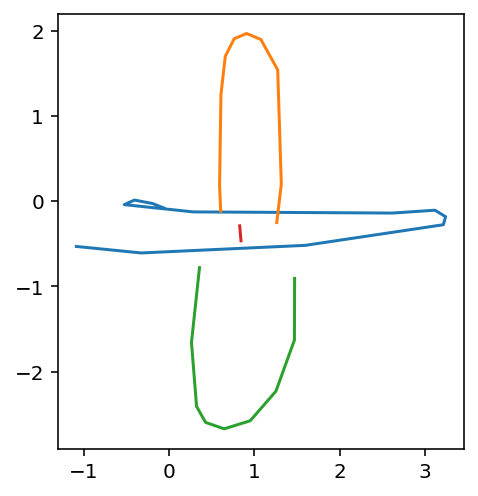

apple


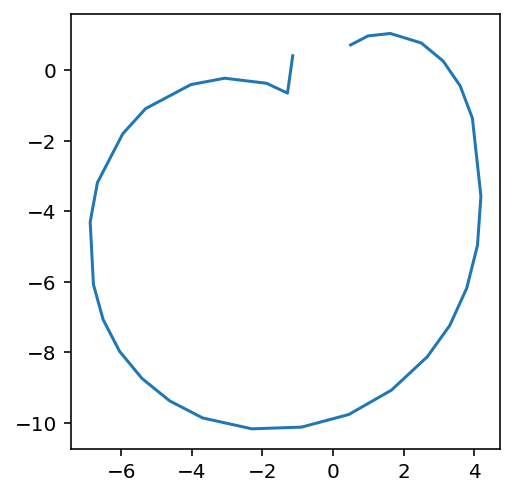

hot air balloon


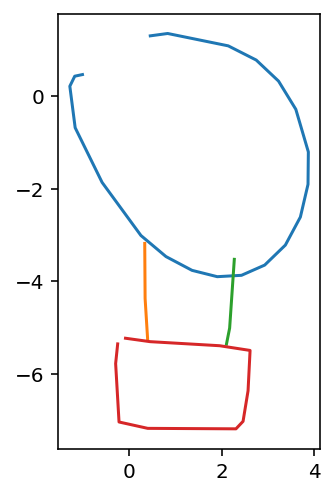

banana


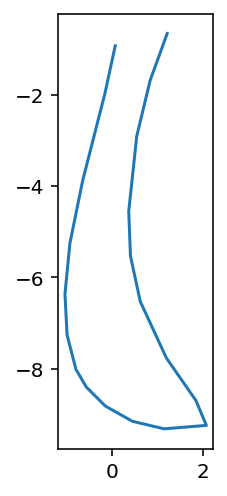

basket


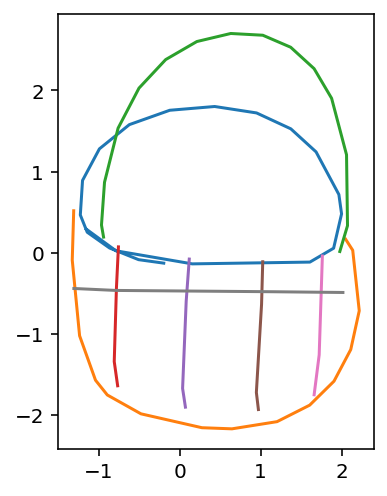

bee


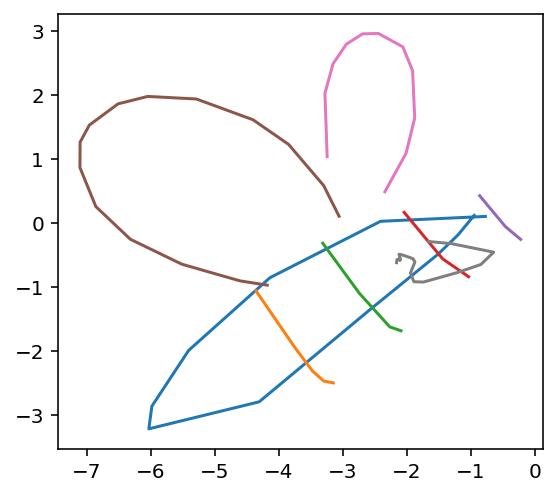

bench


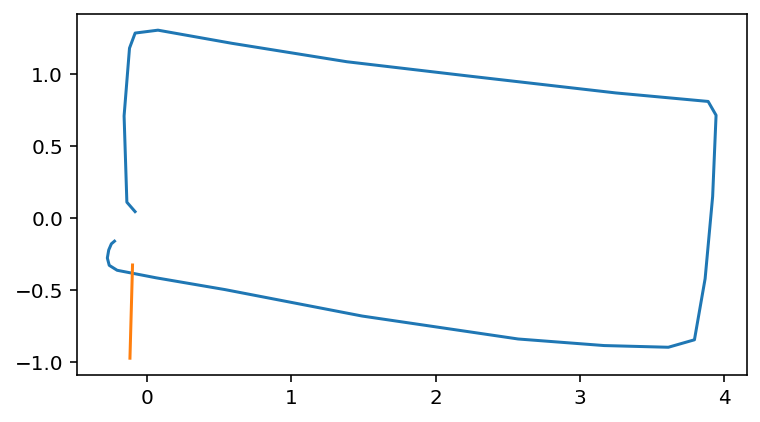

bicycle


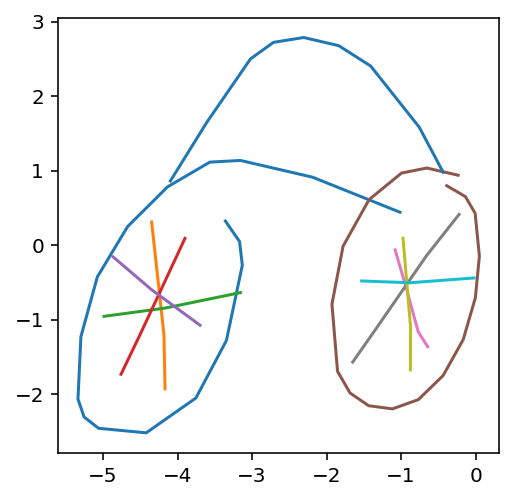

bird


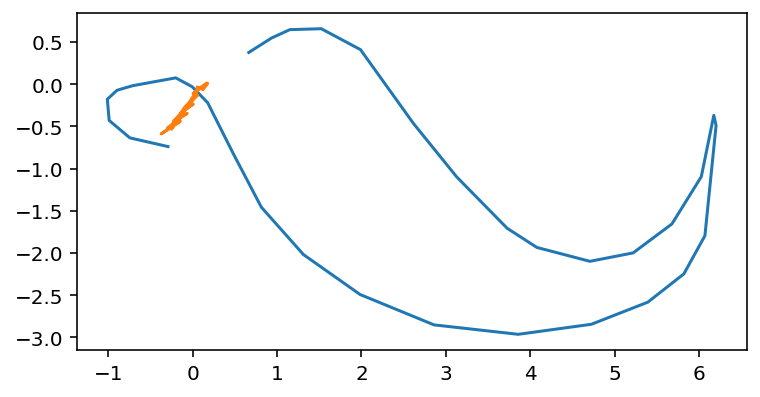

wine bottle


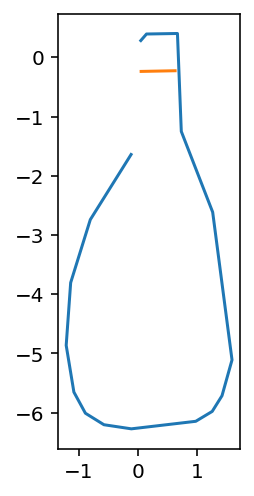

bucket


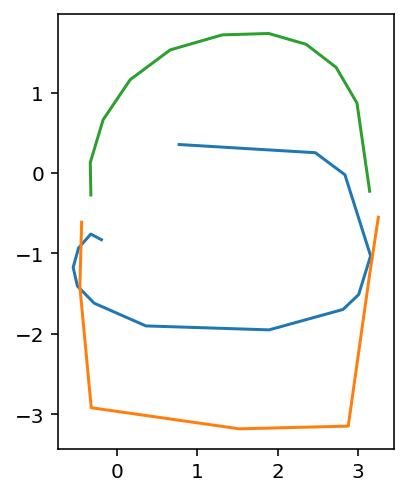

bus


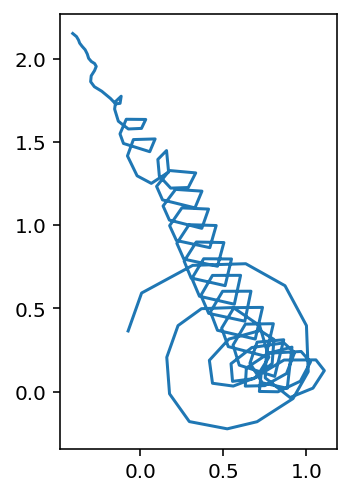

butterfly


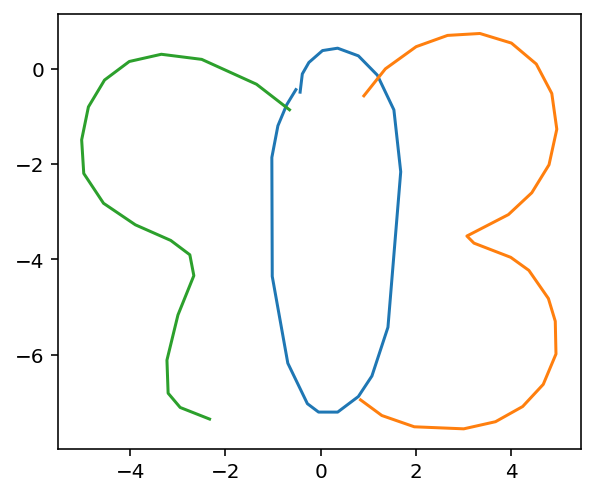

car


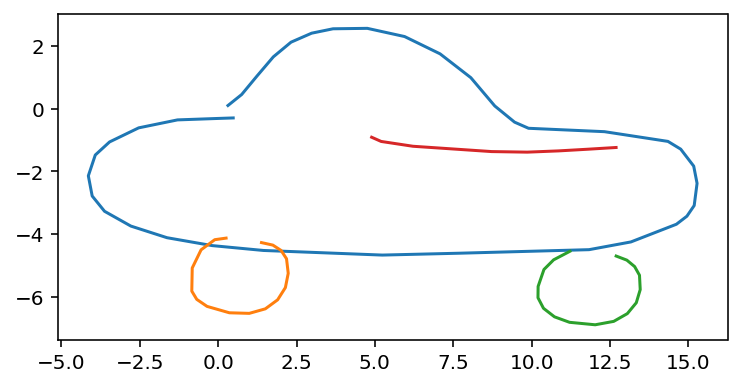

cat


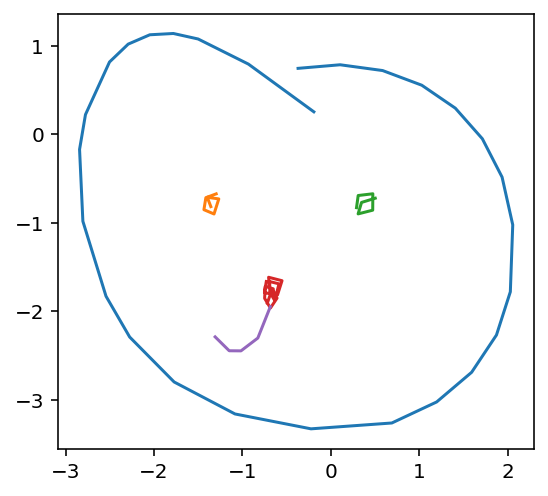

chair


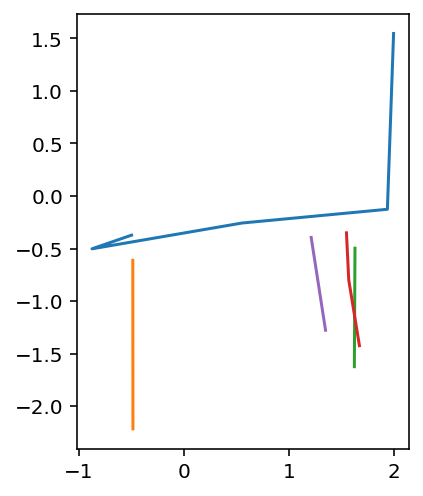

cloud


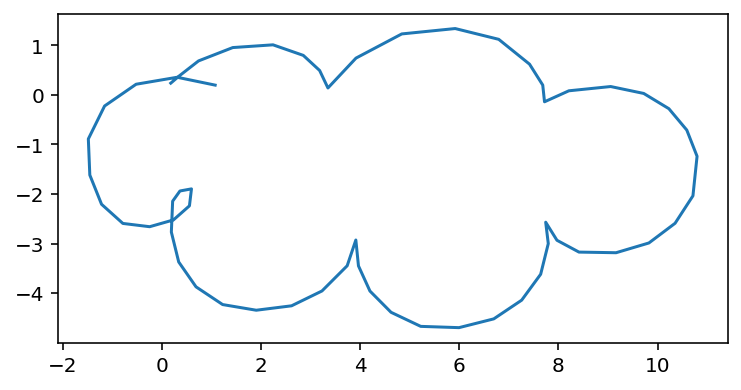

cow


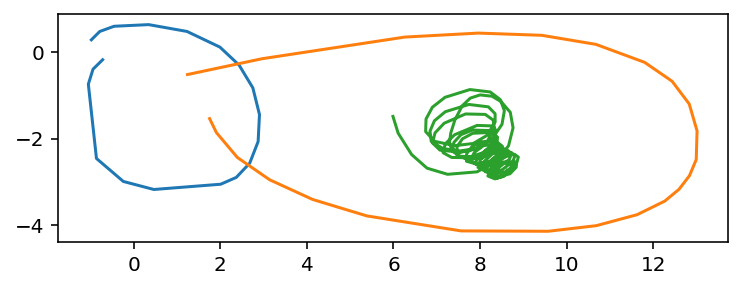

cup


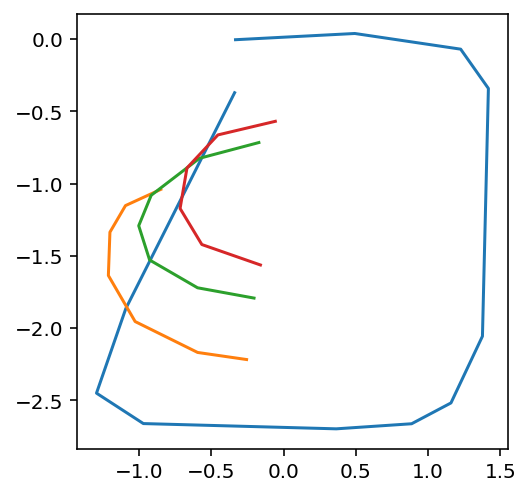

dog


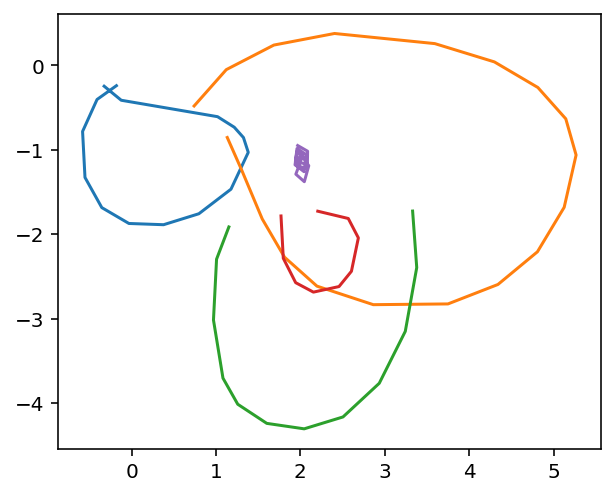

duck


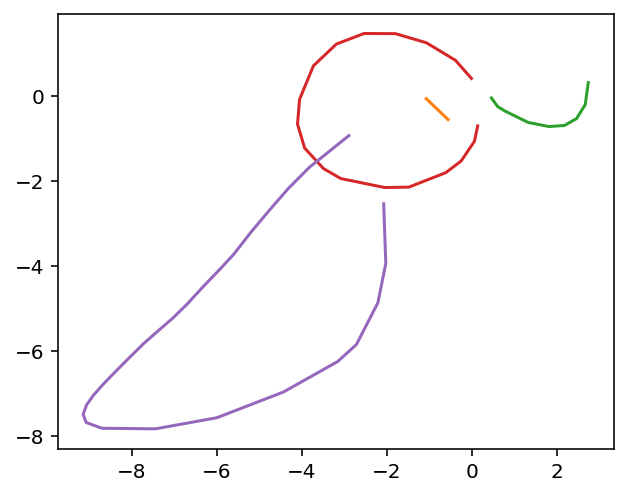

fence


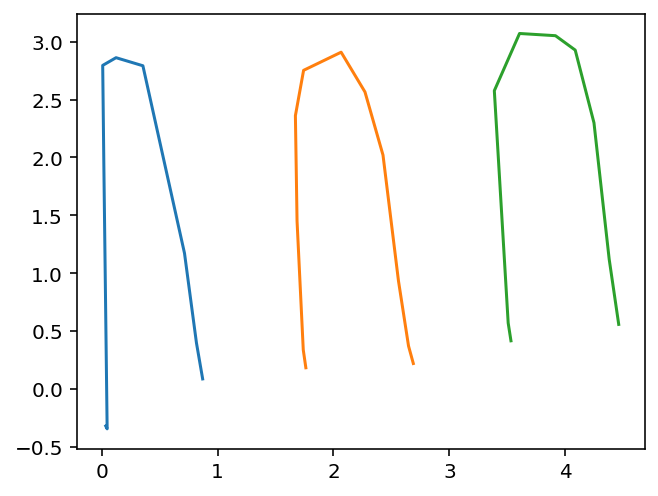

flower


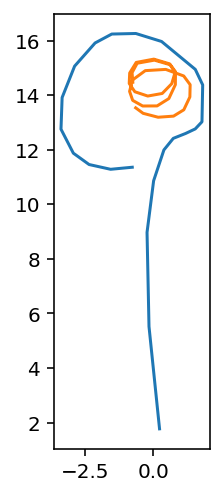

grapes


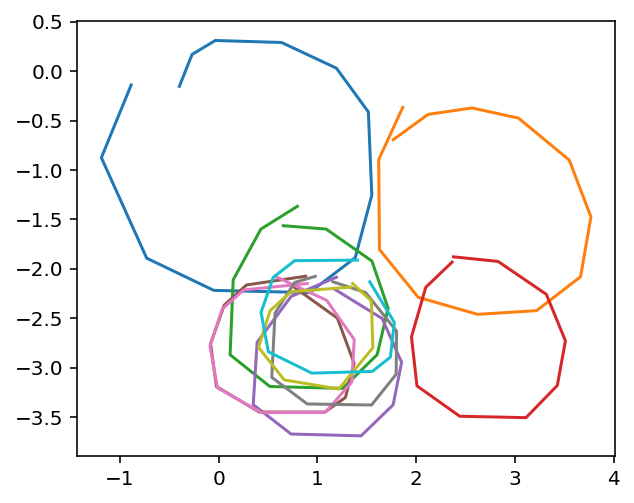

grass


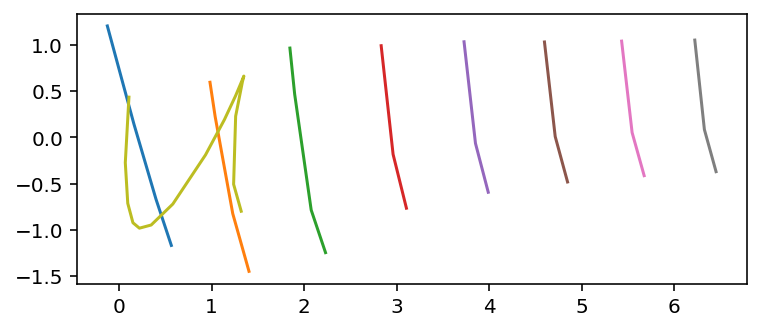

horse


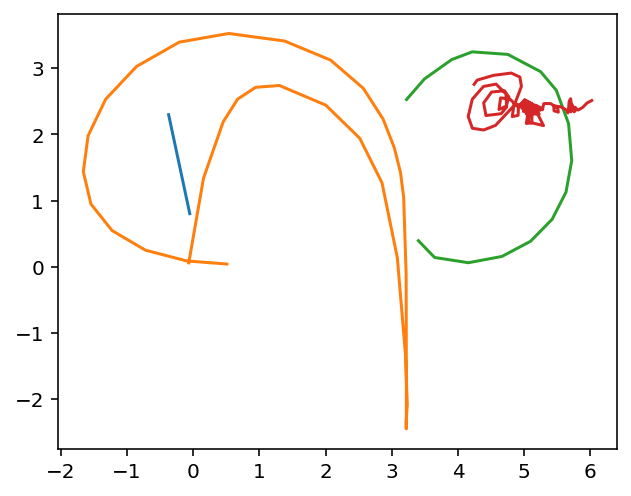

house


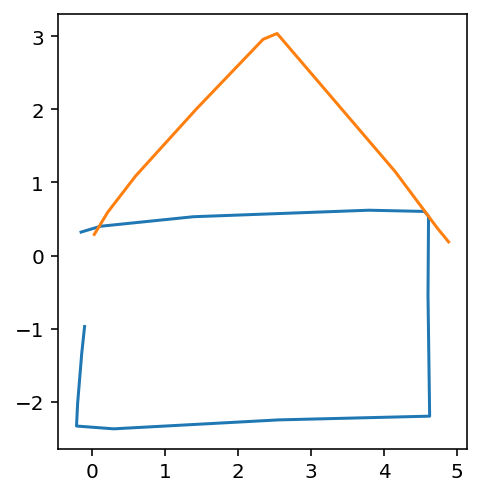

moon


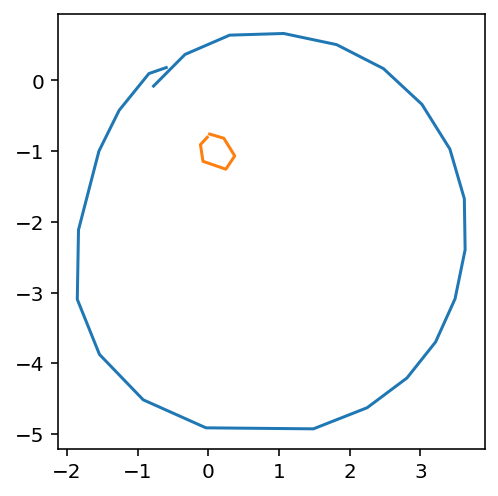

mountain


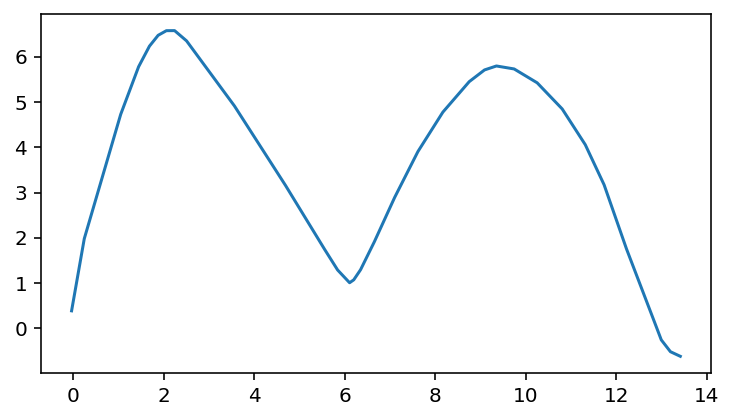

face


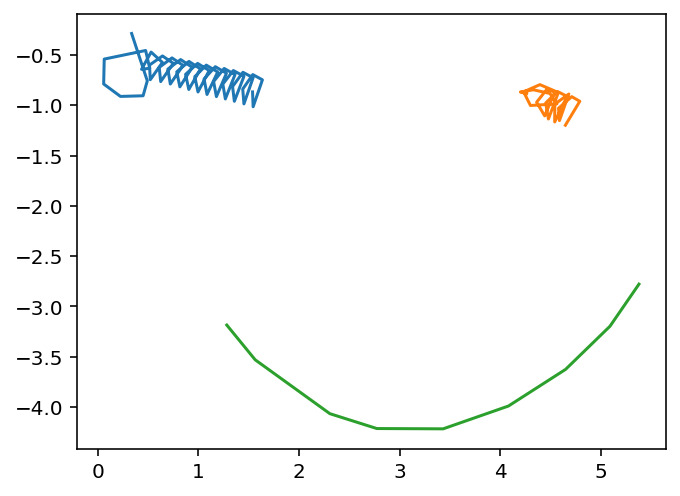

pig


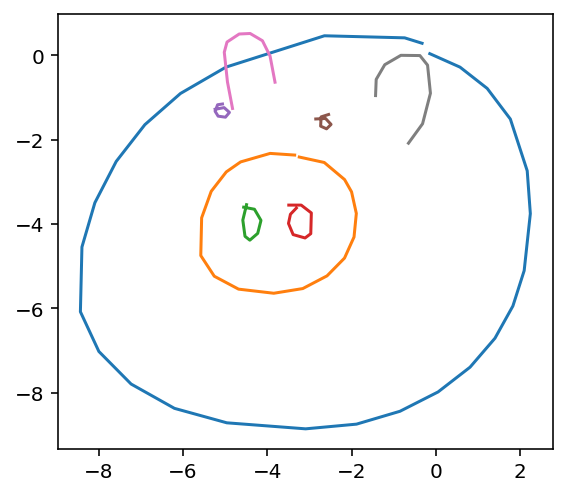

rabbit


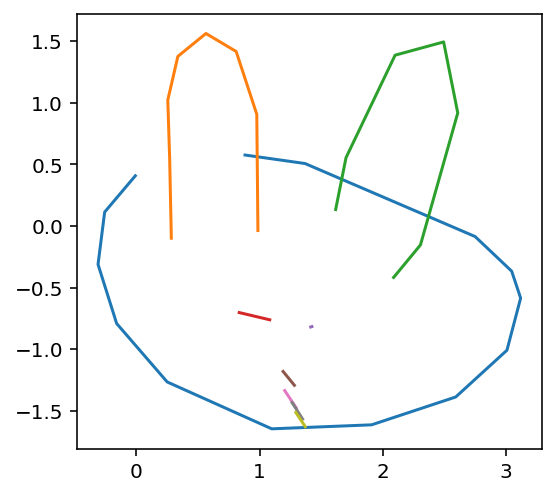

sheep


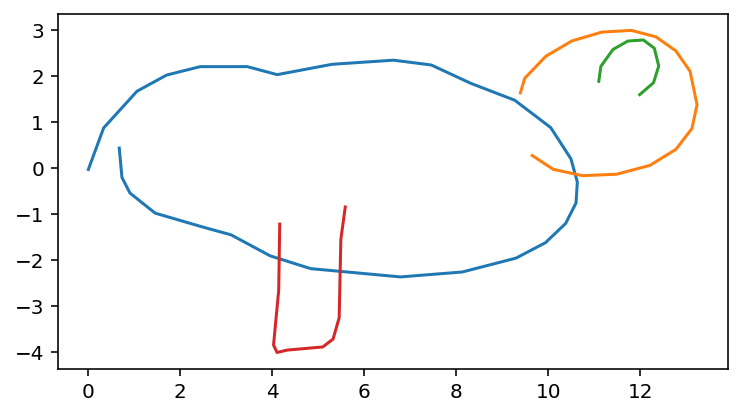

star


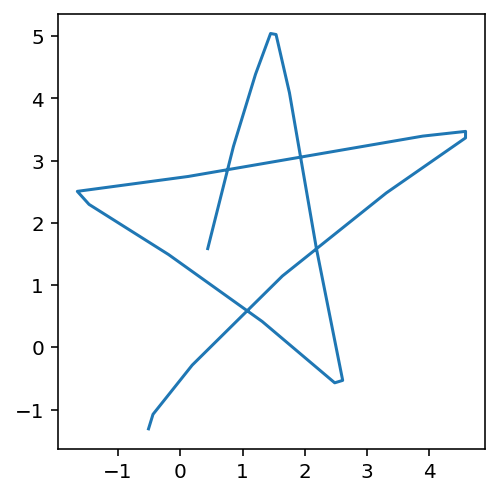

streetlight


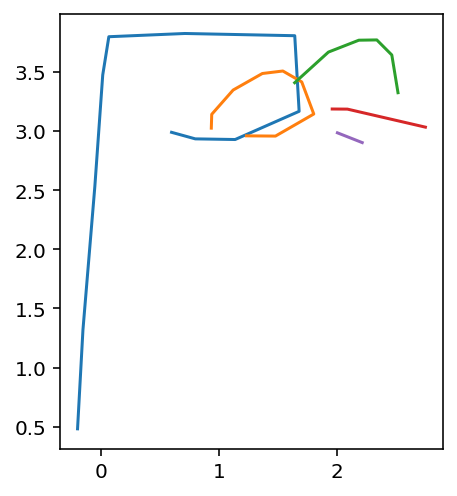

sun


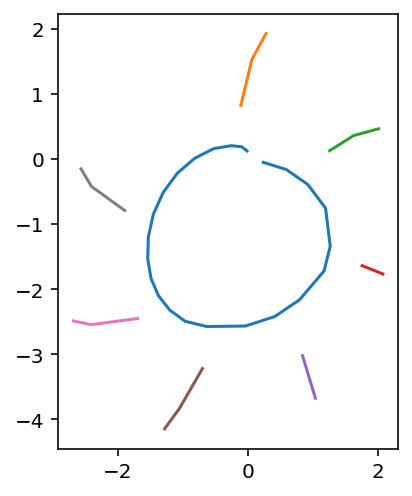

table


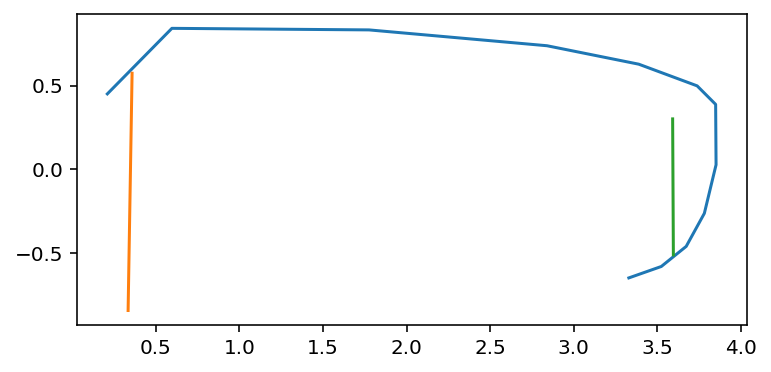

tree


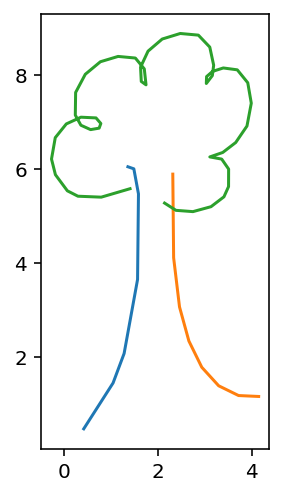

truck


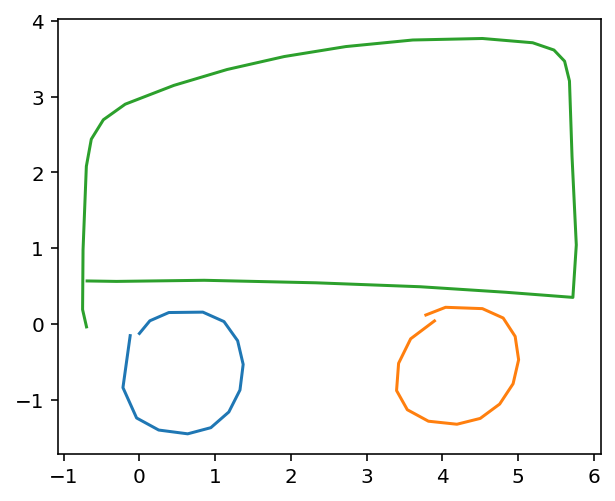

umbrella


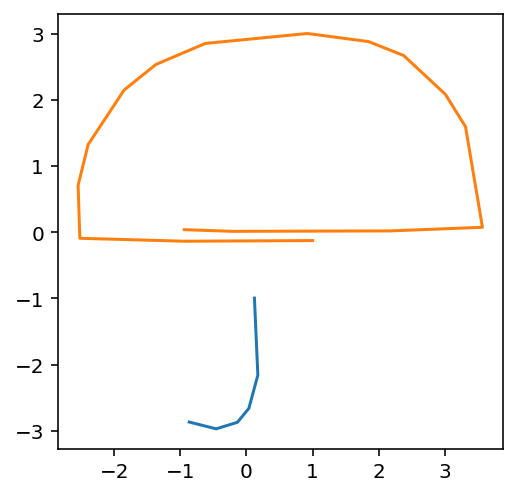

In [12]:
%matplotlib inline

for v, i in sketches.items():
    print(v)
    visualize(i)